In [1]:
from datetime import datetime
import time
start_1 = time.perf_counter()

start_2 = datetime.now()

<a id='intro'></a>
## Simulation of a Single Spectrum

We will simulate the energy spectrum of 3FHL J1230.8+1223 from the Fermi-LAT 3FHL source catalog considering the Dominguez EBL absorption spectral model. To do a simulation, we need to define the observational parameters like
the livetime, the offset, the assumed integration radius, the energy
range to perform the simulation for and the choice of spectral model. We
then use an in-memory observation which is convolved with the IRFs to
get the predicted number of counts. This is Poission fluctuated using
the `fake()` to get the simulated counts for each observation.

<a id='indice'></a>
### Indice
[Step 0.0:  Setting the Engine Tools](#step0)<br>
$\;\;\;\;\;$[Step 0.1:  Importing the Python Necessary Tools](#step0.1)<br>
$\;\;\;\;\;$[Step 0.2:  Defining Functions](#step0.2)<br>
[Step 1.0: Source Information](#step1)<br>
[Step 2.0: Creates the Observation](#step2)<br>
[Step 3.0: Defining the Skymodel](#step3)<br>
[Step 4.0: Simulating the Spectrum](#step4)<br>
$\;\;\;\;\;$[Step 4.1: Defines the geometry](#step4.1)<br> 
$\;\;\;\;\;$[Step 4.2: Setting the Model on the Dataset](#step4.2)<br> 
[Step 5.0: On-Off Analysis](#step5)<br>
$\;\;\;\;\;$[Step 5.1: Simulating the Observations](#step5.1)<br>
$\;\;\;\;\;$[Step 5.2: Plotting Counts, Excess and Significance](#step5.2)<br>
$\;\;\;\;\;$[Step 5.3: Computing the Sensitivity](#step5.3)<br>
$\;\;\;\;\;$[Step 5.4 Computing the Flux Points](#step5.4)<br>

<a id='step0'></a>
## Step 0.0:  Setting the Engine Tools

<a id='step0.1'></a>
### Step 0.1: Importing the Python Necessary Tools

In [2]:
import gammapy
from astropy import units as u
import numpy as np
from astropy.io import ascii
import collections
import sys, os
import matplotlib.pyplot as plt # A collection of command style functions

from gammapy.catalog import SourceCatalog3FHL
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, Observations, observatory_locations
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.irf import load_cta_irfs
from gammapy.maps import MapAxis, RegionGeom

from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

from gammapy.irf import EffectiveAreaTable2D

from numpy.random import RandomState

from scipy.stats import chi2, norm

from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset

# astropy imports
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import fits
from astropy.table import Table, Column

from gammapy.estimators import SensitivityEstimator

# astropy affiliated packages imports
from regions import CircleSkyRegion

from gammapy.stats import WStatCountsStatistic
from gammapy.stats import CashCountsStatistic
from scipy.stats import sem
from gammapy.maps import Map
from regions import PointSkyRegion

import math

from pathlib import Path

In [3]:
path_my_modules = '../my_modules'

In [4]:
path_GAMMAPY_DATA = '/home/born-again/Documents/GitHub/gammapy/gammapy-datasets/1.0.1'
os.environ['GAMMAPY_DATA'] = os.path.join(os.getcwd(), path_GAMMAPY_DATA)

In [5]:
plt.style.use(f"{path_my_modules}/my_plot_style.txt")
# markers = ['H', 'D', 'd', 'P', 'X','o', 'v', '^', '<', '>',  '8', 's', 'p', '*', 'h']
markers=['s','o','^']

In [6]:
format_csv = '.csv'
format_fits = '.fits'

In [7]:
import os
import sys
import importlib

# path_my_modules = '../modules'

module_path = os.path.abspath(f'{path_my_modules}/spectral_models')
if module_path not in sys.path:
    sys.path.append(module_path)

import spectral_models
importlib.reload(spectral_models)
# from spectral_models import pwl_model, get_source_data
from spectral_models import pwl_model, lp_model

module_path = os.path.abspath(f'{path_my_modules}/utilities')
if module_path not in sys.path:
    sys.path.append(module_path)

import utilities
importlib.reload(utilities)
from utilities import mkdir_sub_directory,  LHAASO_table_to_SED_format,  name_to_txt, write_tables_fits, write_tables_csv, number_to_txt
module_path = os.path.abspath(f'{path_my_modules}/config')
if module_path not in sys.path:
    sys.path.append(module_path)

import cfg
importlib.reload(cfg)

<module 'cfg' from '/home/born-again/Documents/GitHub/gammapy/my-notebooks/my_modules/config/cfg.py'>

<a id='step0.2'></a>
### Step 0.2: Defining Functions

In [8]:
def mkdir_base_child(base_dir, child_dir):
    '''Creates a directory: base_dir/child_dir and returs the path 
    mkdir_base_child(base_dir, child_dir)
    >>> path_child
    '''
    path_base = Path(f"{base_dir}")
    path_base.mkdir(exist_ok=True)

    path_child = Path(f"{path_base}/{child_dir}")
    path_child.mkdir(exist_ok=True)
    
    return path_child

In [9]:
def plt_savefig(path_child, child_name):
    ''' Saves figures (.png and .pdf) in the path_child directoty    
    plt_savefig(path_child, child_name)
    >>> plt.savefig(file, bbox_inches='tight')
    '''
    formats_file = [".png", ".pdf"]
    for format_file in formats_file: 
        file = path_child / f'{src_id}_{child_name}_{ebl_ref}{format_file}'
        plt.savefig(file, bbox_inches='tight')


___

🔝 [Back to Top](#intro)<br>

<a id='step1'></a>
## Step 1.0:  Source Information

In [10]:
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance

In [11]:
cosmology.default_cosmology.set(WMAP7)
cosmology.default_cosmology.get()

FlatLambdaCDM(name="WMAP7", H0=70.4 km / (Mpc s), Om0=0.272, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0455)

[source](https://docs.astropy.org/en/stable/api/astropy.cosmology.FlatLambdaCDM.html#astropy.cosmology.FlatLambdaCDM)
+ H0 = Hubble constant at z = 0. If a float, must be in [km/sec/Mpc].
Om0 = Omega matter: density of non-relativistic matter in units of the critical density at z=0.
+ Tcmb0 = Temperature of the CMB z=0. If a float, must be in [K]. Default: 0 [K]. Setting  this to zero will turn off both photons and neutrinos (even massive ones).
+ Neff = Effective number of Neutrino species. Default 3.04.
+ m_nu = Mass of each neutrino species in [eV] (mass-energy equivalency enabled). If this is a scalar Quantity, then all neutrino species are assumed to have that mass. Otherwise, the mass of each species. The actual number of neutrino species (and hence the number of elements of m_nu if it is not scalar) must be the floor of Neff. Typically this means you should provide three neutrino masses unless you are considering something like a sterile neutrino.
+ Ob0 = Omega baryons: density of baryonic matter in units of the critical density at z=0. If this is set to None (the default), any computation that requires its value will raise an exception.



[ATNF Pulsar Catalogue: PSR J1826-1334](https://www.atnf.csiro.au/research/pulsar/psrcat/proc_form.php?version=1.70&Name=Name&JName=JName&RaJD=RaJD&DecJD=DecJD&Dist=Dist&Dist_DM=Dist_DM&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=J1826-1334&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query&table_bottom.x=62&table_bottom.y=11)

[ATNF Pulsar Catalogue: PSR J1826-1256  ](https://www.atnf.csiro.au/research/pulsar/psrcat/proc_form.php?version=1.70&Name=Name&JName=JName&RaJD=RaJD&DecJD=DecJD&Dist=Dist&Dist_DM=Dist_DM&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=J1826-1256+&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query&table_bottom.x=48&table_bottom.y=24)

[ATNF Pulsar Catalogue: PSR J1907+0602  ](https://www.atnf.csiro.au/research/pulsar/psrcat/proc_form.php?version=1.70&Name=Name&JName=JName&RaJD=RaJD&DecJD=DecJD&Dist=Dist&Dist_DM=Dist_DM&Assoc=Assoc&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=J1907%2B0602&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query&table_bottom.x=56&table_bottom.y=16)

[ATNF Pulsar Catalogue: PSR J1907+0631](https://www.atnf.csiro.au/research/pulsar/psrcat/proc_form.php?version=1.70&Name=Name&JName=JName&RaJD=RaJD&DecJD=DecJD&Dist=Dist&Dist_DM=Dist_DM&Assoc=Assoc&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=J1907%2B0631&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query&table_bottom.x=48&table_bottom.y=23)

[ATNF Pulsar Catalogue: PSR J2229+6114](https://www.atnf.csiro.au/research/pulsar/psrcat/proc_form.php?version=1.70&Name=Name&JName=JName&RaJD=RaJD&DecJD=DecJD&Dist=Dist&Dist_DM=Dist_DM&Assoc=Assoc&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=J2229%2B6114&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query&table_bottom.x=58&table_bottom.y=38)

In [12]:
# src_jname = "PSR J1826-1334"  # Pulsar name based on J2000 coordinates;  
# src_id  = src_jname.replace(" ", "_") # Name of identified or likely associated source
# src_rajd, src_decjd = (276.554896, -13.57967) * u.degree
# src_dist = Distance(value = 3.606, unit = u.kpc) # The source distance.

In [13]:
src_jname = "PSR J1826-1256"  # Pulsar name based on J2000 coordinates;  
src_id  = src_jname.replace(" ", "_") # Name of identified or likely associated source
src_rajd, src_decjd = (276.53554, -12.94250) * u.degree
src_dist = Distance(value = 1.550, unit = u.kpc) # The source distance.

In [14]:
# # in the ATNF Pulsar catalog: DIST (kpc) = 3.000; DIST_DM (Kpc)= 5.048
# # In Kothes, R., Uyaniker, B. & Pineault, S. The supernova remnant G106.3+2.7 and its 
# # pulsar-wind nebula: relics of triggered star formation in a complex environment.
# # Astrophys. J. 560, 236–243 (2001) Distance = 0.8 kpc.

# src_jname = "JJ2229+6114"  # Pulsar name based on J2000 coordinates;  
# src_id  = src_jname.replace(" ", "") # Name of identified or likely associated source
# src_rajd, src_decjd = (337.2720, 61.23592) * u.degree
# src_dist = Distance(value = 0.8, unit = u.kpc) # The source distance.


In [15]:
src_red = float(src_dist.compute_z()) # The source redshift for this distance assuming its physical distance is a luminosity distance.
src_dist, src_red

(<Distance 1.55 kpc>, 3.63992475793233e-07)

In [16]:
# src_rajd =Angle('18:26:13.175').degree    # Right ascension (deg)
# src_rajd  = Angle("-13:34:46.8").degree   # Declination (deg)
# # # RAJ: Right ascension (J2000) (hh:mm:ss.s) 
# # # DecJ: Declination (J2000) (+dd:mm:ss)

In [17]:
# src_rajd = 337.2720 # Right ascension (J2000) (degrees)
# src_decjd = 61.23592 # Declination (J2000) (degrees)
print(f"{src_id} Source Information:")
# print(f"(RAJ2000, DEJ2000) = ({src_rajd:.3f}, {src_decjd:.3f}); Redshift = {'{:.3e}'.format(src_red)}")

PSR_J1826-1256 Source Information:


___

🔝 [Back to Top](#intro)<br>

<a id='step2'></a>
## Step 2.0:  Creates the Observation

Define the source position:

In [18]:
# help(SkyCoord)

In [19]:
frame  = "icrs" # International Celestial Reference System (ICRS)
unit   = "deg"  # Degrees units

In [20]:
src_pos = SkyCoord(src_rajd, src_decjd, unit=unit, frame=frame) # Source Position
src_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (276.53554, -12.9425)>

Define the observation parameters (typically the observation duration and the pointing position):


In [21]:
livetime = 5 * u.h # Livetime exposure of the simulated observation

offset = 0.11 * u.deg # Pointing position  offset
pointing = SkyCoord(src_pos.ra, src_pos.dec + offset, unit=unit, frame=frame)
print(pointing)

<SkyCoord (ICRS): (ra, dec) in deg
    (276.53554, -12.8325)>


Load the IRFs:

In [22]:
# # In this simulation, we use the CTA-1DC irfs shipped with gammapy
# base_name = '/home/gamma/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/tutorials/data/caldb/data/cta/prod3b-v2/bcf'
# irfs = load_cta_irfs(base_name + '/North_z20_N_50h/irf_file.fits')

In [23]:
# In this simulation, we use the CTA-1DC irfs shipped with gammapy
base_name = '/home/born-again/Documents/GitHub/gammapy/gammapy-notebooks/0.20.1/tutorials/data/caldb/data/cta/prod3b-v2/bcf'

In [24]:
irf_z = [20,40,60]
irf_h = [0.5, 5, 50]
irf_loc = [("cta_north", "North"),("cta_south", "South")]

In [25]:
irf_site = 1 # 0 or 1

In [26]:
irf_name = f'{irf_loc[irf_site][irf_site]}_z{irf_z[0]}_{irf_h[1]}h'
irf_name

'South_z20_5h'

In [27]:
irf_file = 'irf_file'
irfs = load_cta_irfs(f"{base_name}/{irf_name}/{irf_file}{format_fits}")

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


<AxesSubplot: xlabel='True Energy [TeV]', ylabel='Effective Area [m2]'>

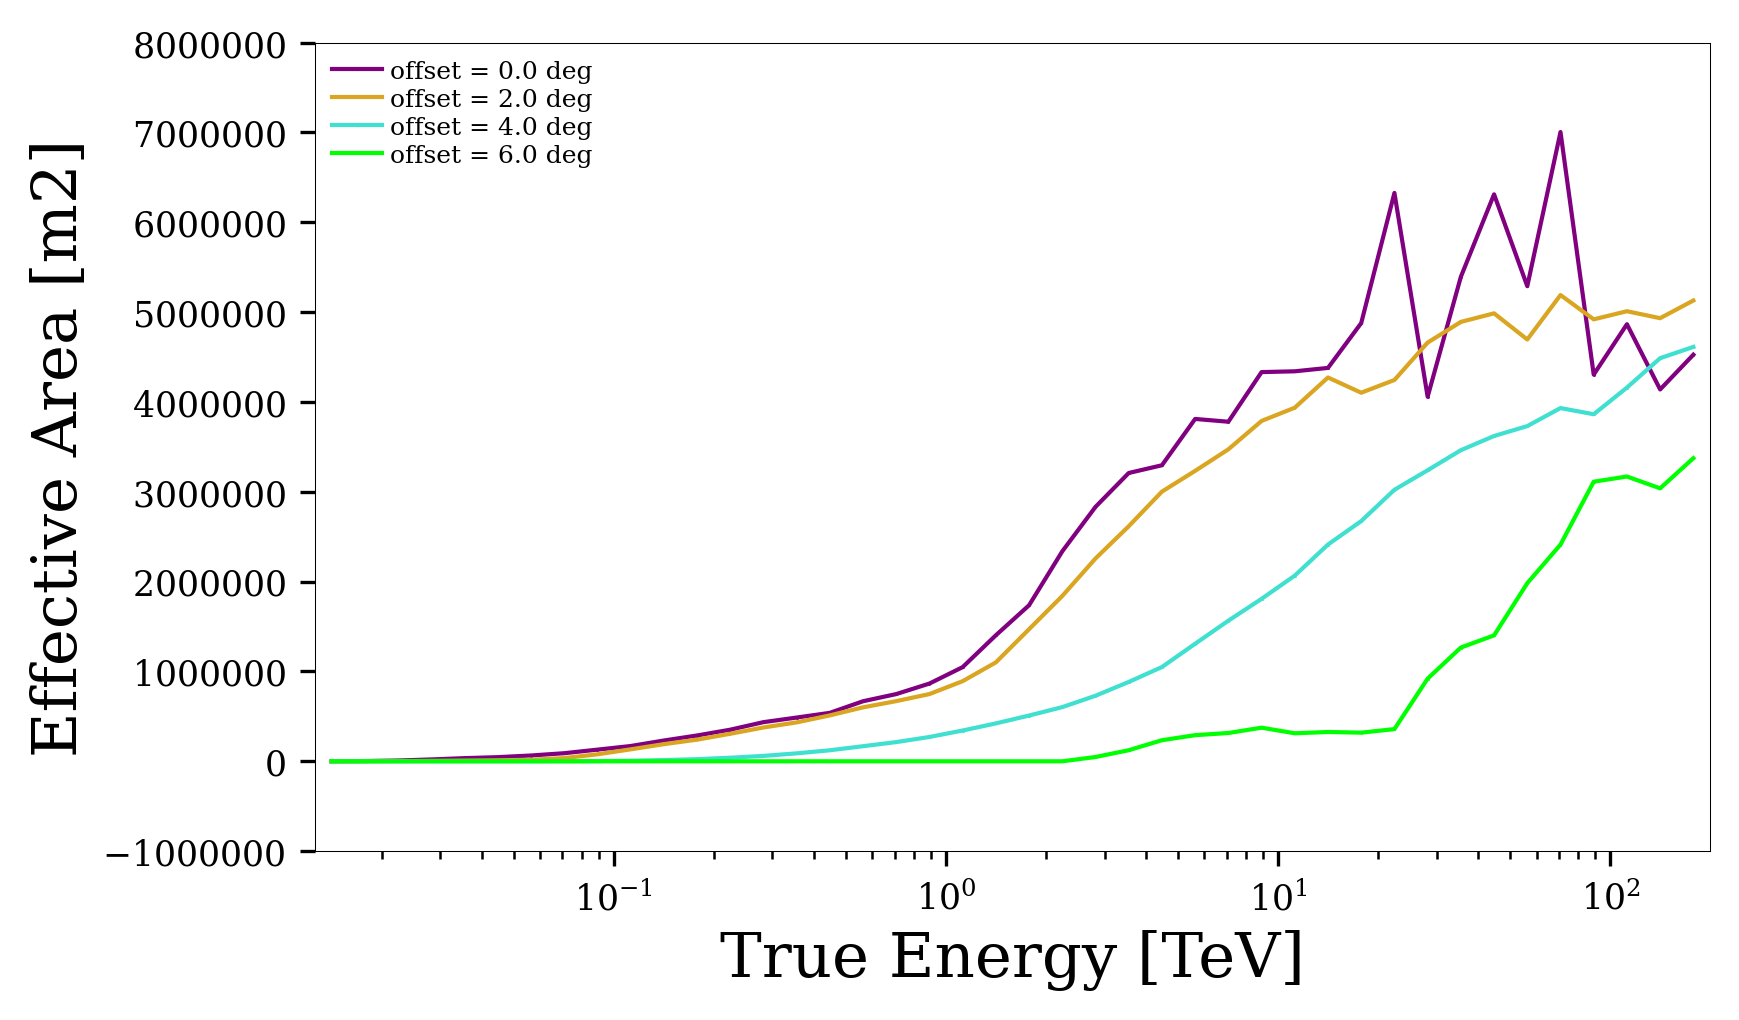

In [28]:
irfs["aeff"].plot_energy_dependence()

Creates a observation:

In [29]:
# help(Observation)

In [30]:
location = observatory_locations[irf_loc[irf_site][0]]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.21
	duration          : 18000.00 s
	pointing (icrs)   : 276.5 deg, -12.8 deg

	deadtime fraction : 0.0%



In [31]:
# help(obs)

___

🔝 [Back to Top](#intro)<br>

<a id='step3'></a>
## Step 3.0:  Defining the Skymodel
Define spectral model:

In [32]:
# A simple Power Law
# index=2.24
# amplitude=6.47e-13 * u.Unit("cm-2 s-1 TeV-1")
# reference=0.1 * u.TeV
    
# model = PowerLawSpectralModel(
#     index=index,
#     amplitude=amplitude,
#     reference=reference,
# )
# # print(pwl)

In [33]:
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling.models import LogParabolaSpectralModel, Models, SkyModel

energy_bounds = [.001, 1000] * u.TeV
# model = LogParabolaSpectralModel(
#     alpha=5.3,
#     amplitude="1e-1 cm-2 s-1 TeV-1",
#     reference=0.1 * u.TeV,
#     beta=0.3,
# )
# model.plot(energy_bounds,sed_type="e2dnde")
# plt.grid(which="both")

In [34]:
from gammapy.modeling.models import LogParabolaSpectralModel, Models, SkyModel

In [35]:
# Last OK
model = LogParabolaSpectralModel(
    alpha=2.3,
    amplitude="1e-10 cm-2 s-1 TeV-1",
    reference=1 * u.TeV,
    beta=0.5,
)
print(model)

LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 1.0000e-10 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral     alpha 2.3000e+00                ... nan  False   False     
spectral      beta 5.0000e-01                ... nan  False   False     


In [36]:
model_in = model.copy()


In [37]:
# model = LogParabolaSpectralModel(
#     alpha=2.3,
#     amplitude="1e-10 cm-2 s-1 TeV-1",
#     reference=1 * u.TeV,
#     beta=0.5,
# )
# print(model)

LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 1.0000e-10 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral     alpha 2.3000e+00                ... nan  False   False     
spectral      beta 5.0000e-01                ... nan  False   False     


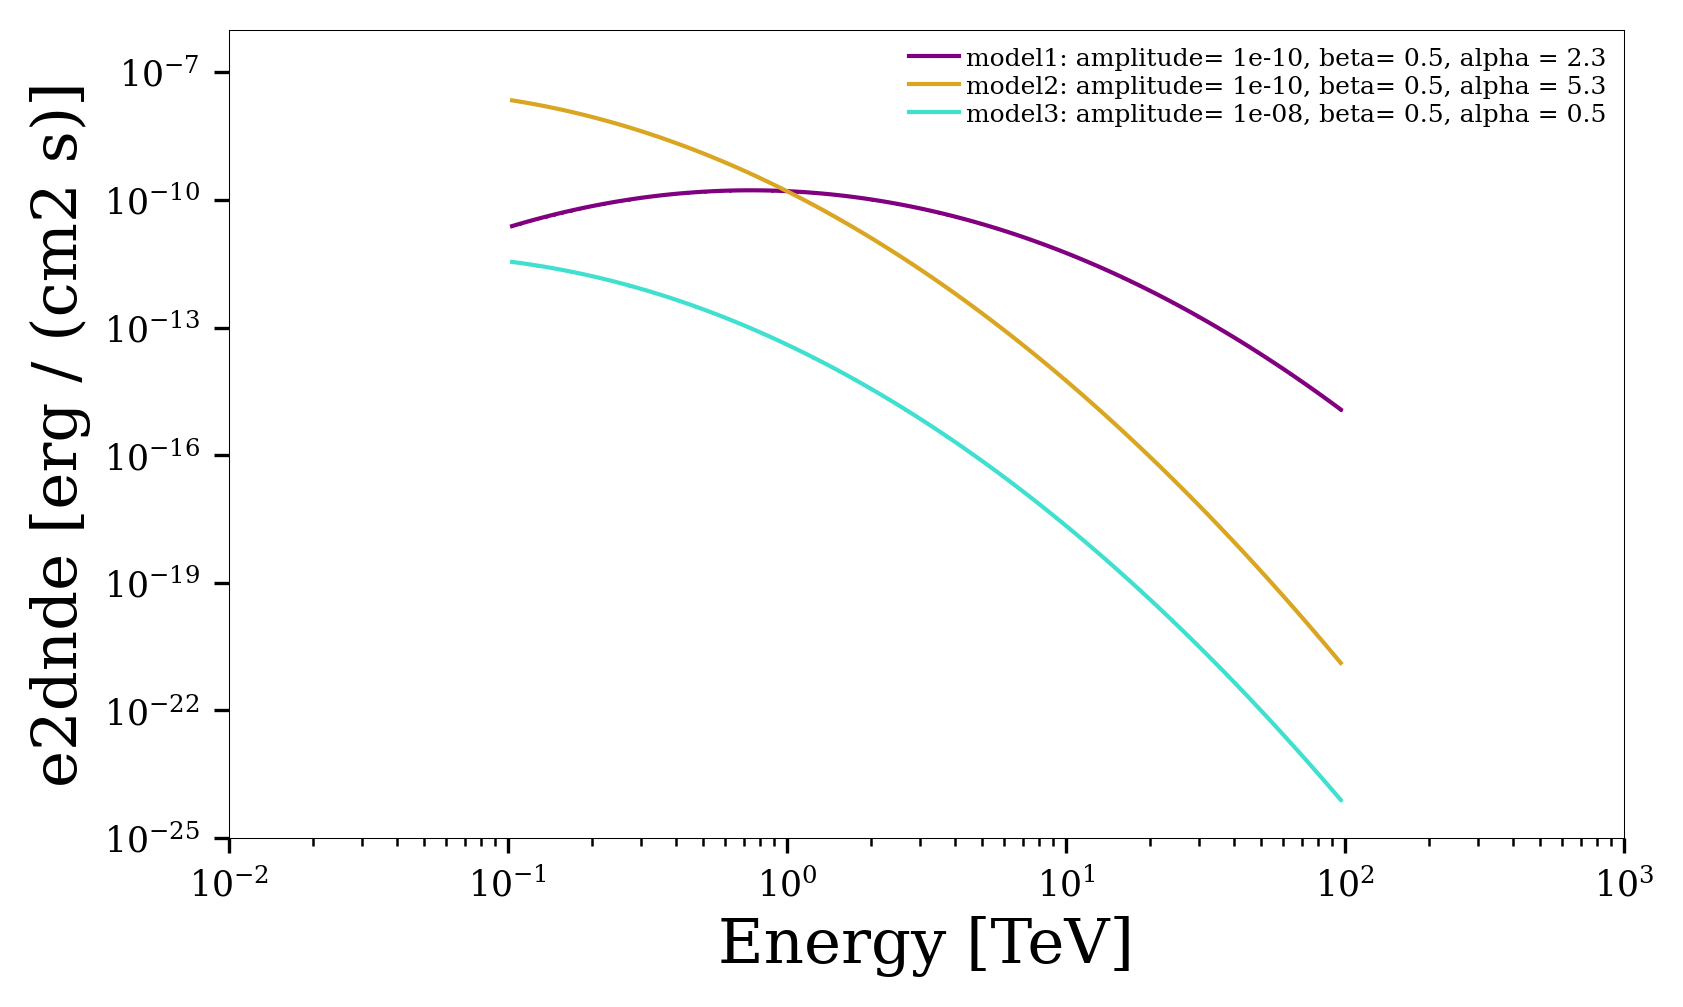

In [40]:
model2 = LogParabolaSpectralModel(
    alpha=5.3,
    amplitude="1e-10 cm-2 s-1 TeV-1",
    reference=1 * u.TeV,
    beta=0.5,
)

model3 = LogParabolaSpectralModel(
    alpha=0.5,
    amplitude="1e-8 cm-2 s-1 TeV-1",
    reference=.010 * u.TeV,
    beta=0.5,
)

energy_bounds = [ 0.1  , 100]* u.TeV 

model.plot(energy_bounds,sed_type="e2dnde", label = f"model1: amplitude= {model.amplitude.value}, beta= {model.beta.value}, alpha = {model.alpha.value}")
model2.plot(energy_bounds,sed_type="e2dnde", label = f"model2: amplitude= {model2.amplitude.value}, beta= {model2.beta.value}, alpha = {model2.alpha.value}")
model3.plot(energy_bounds,sed_type="e2dnde", label = f"model3: amplitude= {model3.amplitude.value}, beta= {model3.beta.value}, alpha = {model3.alpha.value}")

plt.legend()
print(model)

Define absorption model:

In [41]:
ebl_models = ['franceschini', 'dominguez', 'finke'] # Available models in gammapy-data:{'franceschini', 'dominguez', 'finke'}

ebl_ref = ebl_models[1] # dominguez

import astropy.cosmology.units as cu
# cosmo.age([0.5, 1, 1.5] * cu.redshift)  

absorption = EBLAbsorptionNormSpectralModel.read_builtin(
    reference = ebl_ref, 
    redshift=src_red
)
print(absorption)

EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 3.6399e-07      0.000e+00 nan nan   True   False     


The compound spectral model:

In [42]:
absspecmodel =  model * absorption # CompoundSpectralModel
print(absspecmodel)

CompoundSpectralModel
    Component 1 : LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 1.0000e-10 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral     alpha 2.3000e+00                ... nan  False   False     
spectral      beta 5.0000e-01                ... nan  False   False     
    Component 2 : EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 3.6399e-07      0.000e+00 nan nan   True   False     
    Operator : mul



Setting the sky model used in the dataset:

In [43]:
skymodel = SkyModel(
    spectral_model=model, 
  
#     spectral_model=absspecmodel, 
    name="model_simu"
)
print(skymodel)

SkyModel

  Name                      : model_simu
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-10   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                         :      2.300   +/-    0.00             
    beta                          :      0.500   +/-    0.00             




___

🔝 [Back to Top](#intro)<br>

<a id='step4'></a>
## Step 4.0:  Simulating the Spectrum
<a id='step4.1'></a>
### Step 4.1: Defines the geometry

In [44]:
# Defines the energy range
e_edges_min = 0.1 * u.TeV   # Minimum energy
e_edges_max = 100. * u.TeV # Maximum energy

In [45]:
# Reconstructed energy axis
energy_reco = MapAxis.from_energy_bounds(
    e_edges_min, 
    e_edges_max, 
    nbin=5, 
    per_decade=True, 
    name="energy"
)
# print(energy_reco)

In [46]:
# Defines the on region:
on_region_radius = Angle("0.11 deg")

on_region = CircleSkyRegion(
    center=src_pos, 
    radius=on_region_radius
)
print(on_region)

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (276.53554, -12.9425)>
radius: 0.11 deg


In [47]:
#Defines the geometry:
geom = RegionGeom.create(
    region=on_region, 
    axes=[energy_reco]
)

<a id='step4.2'></a>
### Step 4.2: Setting the Model on the Dataset

In [48]:
# Defines the true energy axis:
# true energy axis should be wider than reco energy axis
energy_true = MapAxis.from_energy_bounds(
    0.3*e_edges_min, 
    3*e_edges_max, 
    nbin=8, 
    per_decade=True, 
    name="energy_true"
)
# print(energy_true)

In [49]:
# Create a MapDataset object with zero filled maps.
dataset_empty = SpectrumDataset.create(
    geom=geom, 
    energy_axis_true=energy_true,
    name="obs-0"
)

In [50]:
# Make spectrum for a single IACT observation:
# The irfs and background are computed at a single fixed offset, which is recommended only for point-sources.
maker = SpectrumDatasetMaker(
#     containment_correction=True, # Apply containment correction for point sources and circular on regions.
    selection=["edisp", "background", "exposure"], # Selecting which maps to make
    use_region_center=False
)
safe_maker = SafeMaskMaker(methods=["bkg-peak"], aeff_percent=10) # Make safe data range mask for a given observation.

In [51]:
# help(SpectrumDatasetMaker)

In [52]:
# Make map dataset:
dataset = maker.run(dataset_empty, obs) 
dataset = safe_maker.run(dataset, obs)

In [53]:
# Set the model on the dataset, and fake
dataset.models = skymodel
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 52816 
  Total background counts         : 775.17
  Total excess counts             : 52040.83

  Predicted counts                : 53074.99
  Predicted background counts     : 775.17
  Predicted excess counts         : 52299.83

  Exposure min                    : 5.78e+08 m2 s
  Exposure max                    : 1.10e+11 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -821883.62

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : model_simu
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      amplitude         

You can see that background counts are now simulated.

___

🔝 [Back to Top](#intro)<br>

<a id='step5'></a>
### Step 5.0: On-Off Analysis

To do an on off spectral analysis, which is the usual science case, the
standard would be to use `SpectrumDatasetOnOff`, which uses the
acceptance to fake off-counts

<a id='step5.1'></a>
### Step 5.1: Simulating the Observations

In [54]:
# Spectrum dataset for on-off likelihood fitting.
dataset_onoff = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, 
    acceptance=1, 
    acceptance_off=5
)

# Simulate fake counts (on and off) for the current model and reduced IRFs.
dataset_onoff.fake(
    random_state='random-seed', 
    npred_background=dataset.npred_background()
)

print(dataset_onoff)

SpectrumDatasetOnOff
--------------------

  Name                            : HPYkRCDB 

  Total counts                    : 52887 
  Total background counts         : 771.20
  Total excess counts             : 52115.80

  Predicted counts                : 53071.57
  Predicted background counts     : 771.74
  Predicted excess counts         : 52299.83

  Exposure min                    : 5.78e+08 m2 s
  Exposure max                    : 1.10e+11 m2 s

  Number of total bins            : 15 
  Number of fit bins              : 15 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 17.60

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : model_simu
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      amplitude

In [55]:
# Class to compute statistics for Poisson distributed variable with unknown background.
significance = WStatCountsStatistic(
    n_on=sum(dataset_onoff.counts.data), 
    n_off=sum(dataset_onoff.counts_off.data), 
    alpha=0.2).sqrt_ts
print(significance)

[[403.41913773]]


In [56]:
n_obs = 10 # We simulate each observation n_obs times, to randomize the renortets

In [57]:
datasets = Datasets()

for idx in range(n_obs):
    dataset_onoff.fake(
        random_state=idx, 
        npred_background=dataset.npred_background()
    )
    dataset_fake = dataset_onoff.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

table = datasets.info_table()
print(table)

 name counts     excess    ... acceptance   acceptance_off         alpha       
                           ...                                                 
----- ------ ------------- ... ---------- ----------------- -------------------
obs-0  53319 52544.3984375 ...       15.0              75.0 0.20000000298023224
obs-1  52574       51802.0 ...       15.0 74.99999999999999 0.20000000000000004
obs-2  52873       52086.0 ...       15.0 74.99999999999999 0.20000000000000004
obs-3  52839       52054.4 ...       15.0 74.99999999999999 0.20000000000000004
obs-4  53349       52582.8 ...       15.0              75.0 0.19999999999999998
obs-5  52911       52117.8 ...       15.0 74.99999999999999 0.20000000000000004
obs-6  53113       52335.4 ...       15.0 74.99999999999997  0.2000000000000001
obs-7  52863       52076.4 ...       15.0              75.0                 0.2
obs-8  53090       52318.6 ...       15.0 74.99999999999997 0.20000000000000007
obs-9  53011       52244.6 ...       15.

<a id='step5.2'></a>
### Step 5.2: Plotting Counts, Excess and Significance

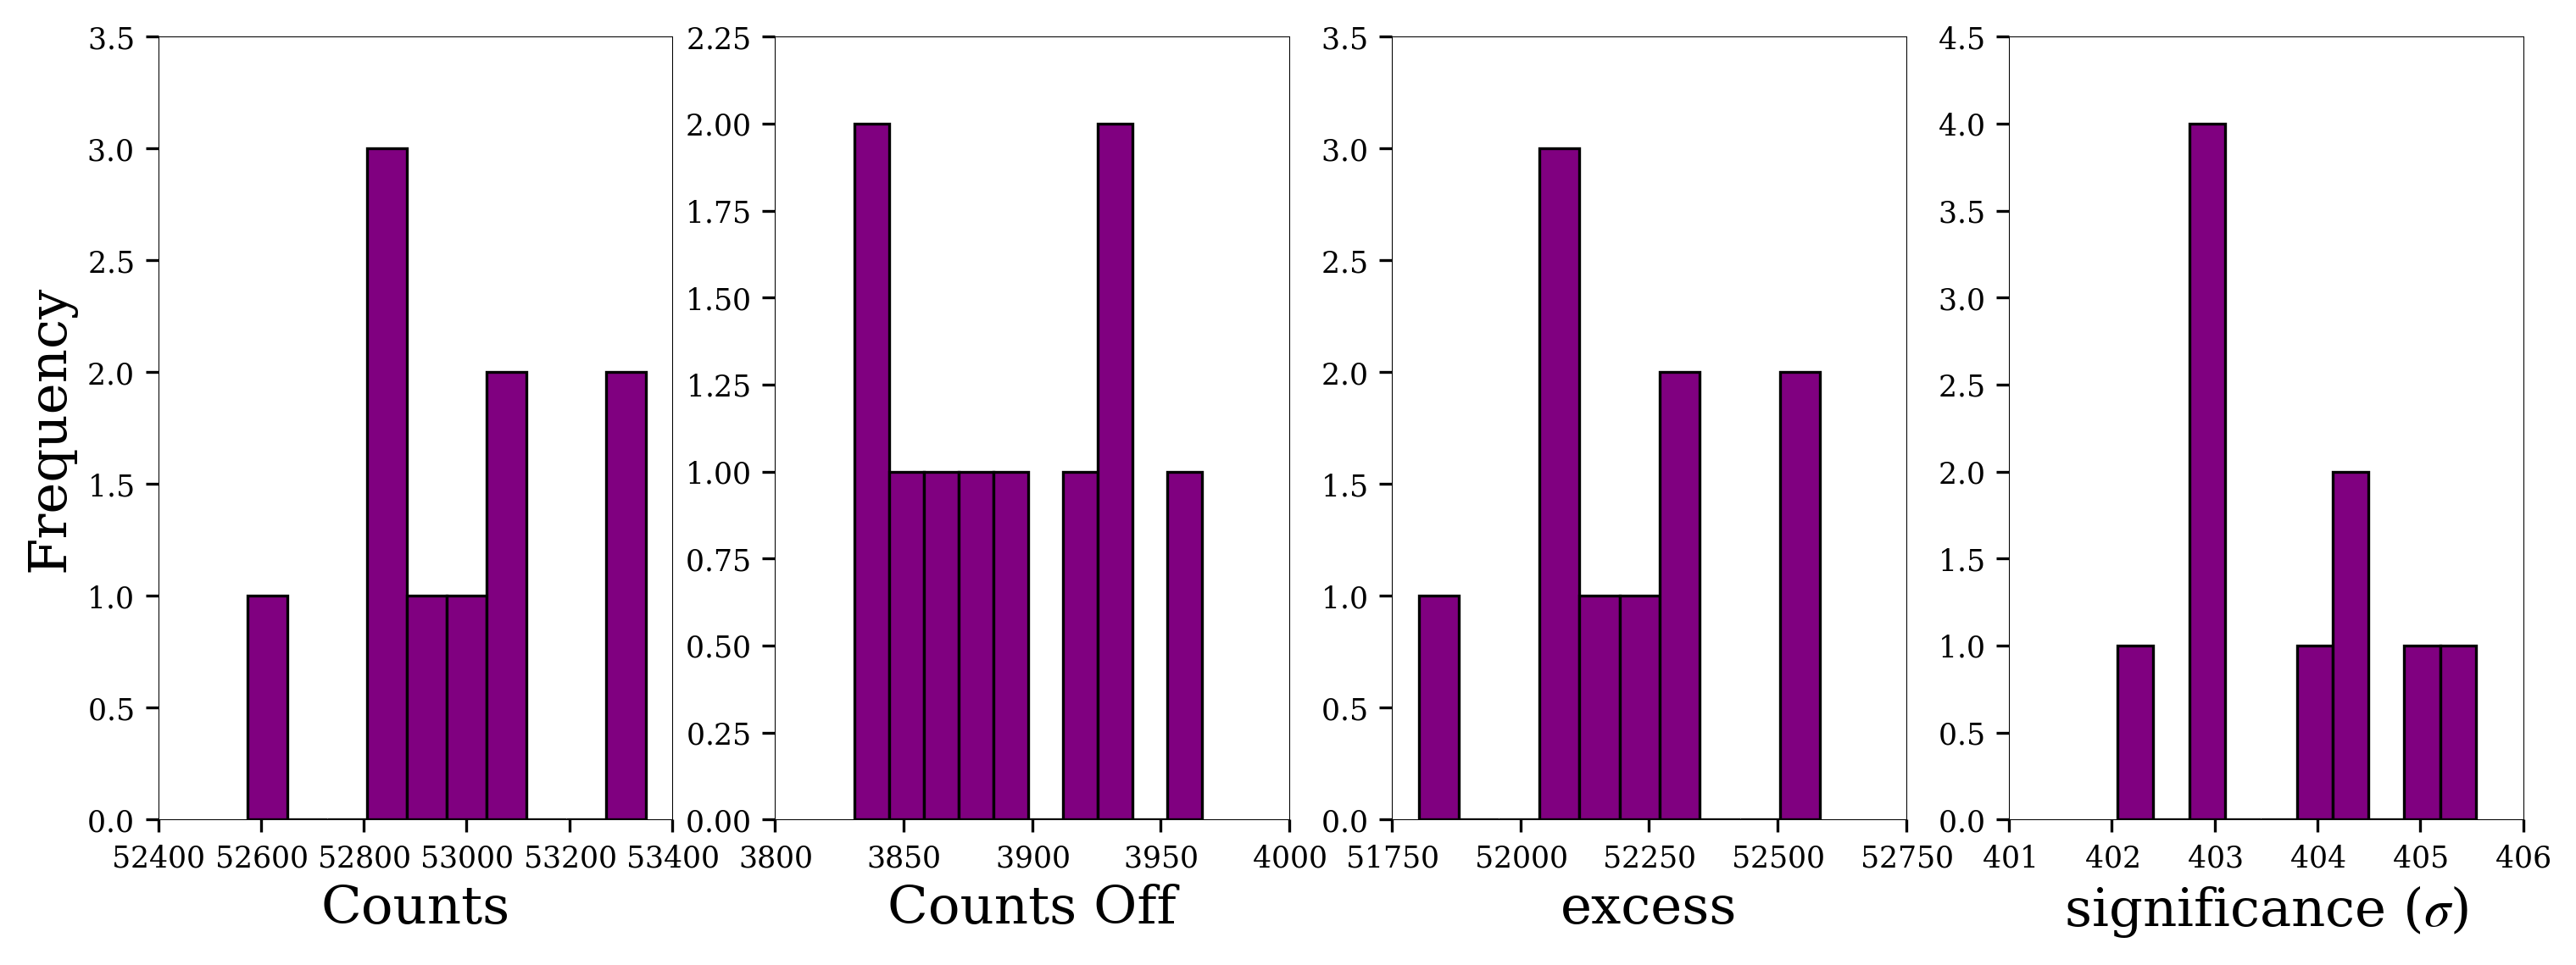

In [58]:
fix, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[0].set_ylabel("Frequency");

axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off");

axes[2].hist(table["excess"])
axes[2].set_xlabel("excess");

axes[3].hist(table["sqrt_ts"])
axes[3].set_xlabel(r"significance ($\sigma$)");

path_counts = mkdir_base_child("analysis", "counts")

plt_savefig(path_counts, "counts")

<a id='step5.3'></a>
### Step 5.3: Computing the Sensitivity

CTAO Northern Array: 

4 Large-Sized Telescopes and 9 Medium-Sized Telescopes (area covered by the array of telescopes: ~0.25 km2)


CTAO Southern Array: 

14 Medium-Sized Telescopes and 37 Small-Sized Telescopes (area covered by the array of telescopes: ~3 km2)

In [59]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, 
    n_sigma=3, 
    bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_onoff)
print(sensitivity_table)

 energy      e2dnde     excess background  criterion  
  TeV    erg / (cm2 s)                                
-------- ------------- ------- ---------- ------------
0.125893   8.27289e-13 64.9628        366 significance
0.199526   5.91327e-13  47.578      191.6 significance
0.316228   4.40603e-13 33.5715       91.8 significance
0.501187   4.15581e-13 26.0505       53.2 significance
0.794328   3.60135e-13 17.1326         21 significance
 1.25893   2.33923e-13 13.8258       12.8 significance
 1.99526   2.48596e-13 11.5892        8.4 significance
 3.16228   2.00628e-13 10.1116          6 significance
 5.01187   3.11564e-13 9.55473        5.2 significance
 7.94328   3.19714e-13 9.40893          5 significance
 12.5893   3.17057e-13 6.46666        1.8 significance
 19.9526    6.3985e-13 7.14856        2.4 significance
 31.6228   5.81352e-13 5.00403        0.8 significance
 50.1187   7.84926e-13       5        0.4        gamma
 79.4328   1.39728e-12       5          0        gamma


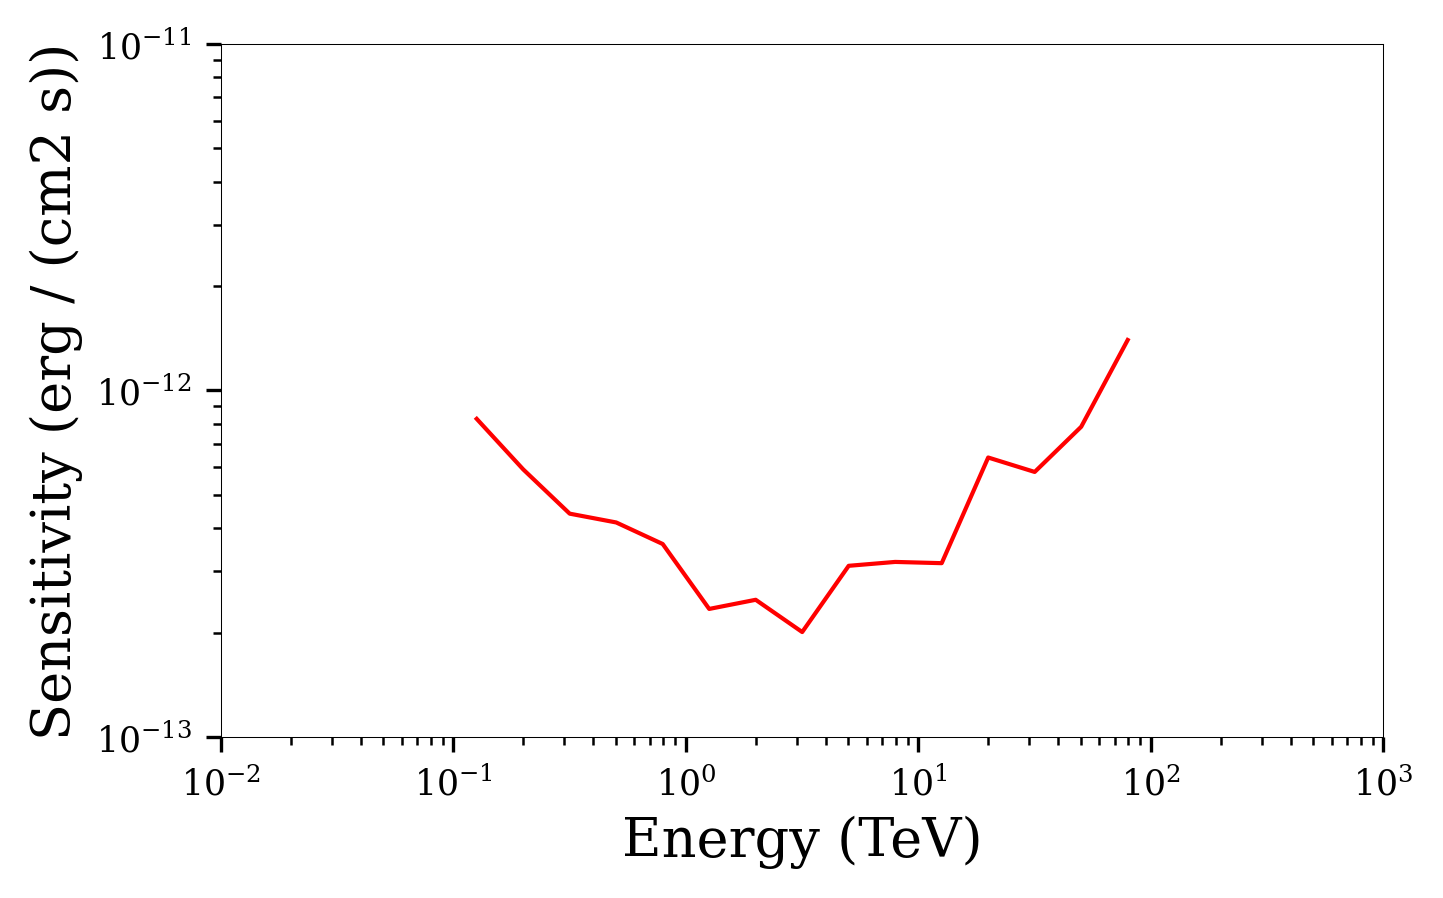

In [60]:
# Plot the sensitivity curve
t = sensitivity_table

fix, axes = plt.subplots(figsize=(5, 3))

axes.plot(t["energy"], t["e2dnde"], "s-", color="red")
axes.loglog()

axes.set_xlabel(f"Energy ({t['energy'].unit})", size=13)
axes.set_ylabel(f"Sensitivity ({t['e2dnde'].unit})", size=13)

path_dir = mkdir_base_child(src_id, "sensitivity")

file_name = f'sensitivity_{irf_name}'

plt_savefig(path_dir,  file_name)

In [61]:
f"{name_to_txt(src_id)}_{irf_name}"

'PSR_J1826-1256_South_z20_5h'

In [62]:
file_name_sens = f"{src_id}_{irf_name}"
path_file = path_dir = mkdir_base_child(src_id, "sensitivity")
write_tables_csv(t, path_file, file_name_sens)

<a id='step5.4'></a>
### Step 5.4:  Computing the Flux Points

We can now compute some flux points using the `~gammapy.estimators.FluxPointsEstimator`. 

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name. 

In [63]:
#Compute flux points
datasets.models = [skymodel]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = skymodel.copy()

 

energy_edges = MapAxis.from_energy_bounds(e_edges_min,e_edges_max, nbin=12).edges

fpe = FluxPointsEstimator(energy_edges=energy_edges, source="model_simu", selection_optional="all")
flux_points = fpe.run(datasets=datasets)


In [64]:
energy_edges

<Quantity [1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
           1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
           1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
           1.00000000e+02] TeV>

In [65]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,stat_scan,norm_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.12589254117941673,0.10000000000000002,0.15848931924611137,1.3718878403861784e-09,7.924991242587758e-11,1.0200454775580381e-11,1.0025815147143124,0.006102166787437409,0.00609170431943129,0.006112793406799488,1.0148336263802085,61950.65982139883,248.8988947773751,3462.6033420677577 .. 3454.915049611161,3089.3577 .. 3089.3577,7.730610679020174,False,3474.0 .. 3434.0,True,32523.270564423117 .. 140931.69890741492,0.2 .. 4.999999999999999
0.19952623149688797,0.15848931924611137,0.25118864315095807,1.1102405462391763e-09,1.0120554914048686e-10,2.0481486717214978e-11,1.0012139712551194,0.004268469815548454,0.0042626993572514316,0.004274266829982443,1.009775173972518,159688.43248415412,399.61035082209037,5917.589469756869 .. 5916.260530027015,5725.2046 .. 5725.2046,19.397493877026136,False,5946.0 .. 5832.0,True,78115.91425722191 .. 269881.22619974,0.2 .. 4.999999999999999
0.3981071705534973,0.25118864315095807,0.6309573444801934,5.432877118076641e-10,1.9333621630662424e-10,7.760519781782113e-11,0.998413897087478,0.0023494794020683016,0.002347673807774875,0.002351316703377471,1.00312232869386,599264.4632990723,774.1217367436935,18385.63038725846 .. 18381.29594226119,18236.422 .. 18236.422,13.433402227965416,False,18397.0 .. 18250.0,True,279576.68697014335 .. 871635.8761300193,0.2 .. 4.999999999999999
0.7943282347242816,0.6309573444801934,1.0,1.650443949575553e-10,6.044683443773318e-11,4.753783657252233e-11,0.9986835882210603,0.003578606783032555,0.0035743414210456237,0.003582853406397213,1.0058592065934209,269165.31811305624,518.8114475539801,7837.577862520986 .. 7836.987904351755,7816.027 .. 7816.027,15.675472566275857,False,8112.0 .. 7764.0,True,123680.76695138817 .. 374128.3344925732,0.2 .. 4.999999999999999
1.2589254117941675,1.0,1.584893192461114,5.723013455047925e-11,3.35682017379596e-11,4.150633591161733e-11,1.0035296471459614,0.0034534899318889732,0.003449571124308548,0.0034574772964466316,1.0104646570024858,296361.05298047874,544.3905335147542,8470.59546933955 .. 8471.835341261287,8458.977 .. 8458.977,10.709733498602873,False,8539.0 .. 8665.0,True,135878.76732870072 .. 401844.4091325126,0.2 .. 4.999999999999999
1.9952623149688802,1.584893192461114,2.5118864315095806,1.605573278112014e-11,1.513693614350013e-11,2.94292193214014e-11,1.0018442959957925,0.004695102193519025,0.004687826691549324,0.004702455746552037,1.011266918672796,159066.51695454825,398.83143927547667,4572.147600406925 .. 4571.957894583319,4563.544 .. 4563.544,3.8393085258139763,False,4582.0 .. 4610.0,True,72962.65620555081 .. 217368.89464108262,0.2 .. 4.999999999999999
3.9810717055349727,2.5118864315095806,6.309573444801932,1.6036266355996274e-12,7.189346278761185e-12,2.486509024832766e-11,0.99870768762523,0.005071296370150913,0.005062764701022182,0.0050798641532503915,1.0088858668044256,134450.738054275,366.6752487614551,3902.9223373891587 .. 3902.3721558081397,3891.1316 .. 3891.1316,23.730280311536262,False,3836.0 .. 3996.0,True,61696.99102360152 .. 186279.52822211722,0.2 .. 4.999999999999999
7.943282347242814,6.309573444801932,9.999999999999998,9.943390375897013e-14,3.9756886369142507e-13,3.0071685808685617e-12,0.978092813706838,0.016504139413209874,0.016412465377804965,0.016595712757873395,1.0114575399661385,11564.659398940874,107.5391063703845,357.27054002963285 .. 360.06729167040066,355.0647 .. 355.0647,11.681750574165108,False,362.0 .. 361.0,True,5323.420569296944 .. 17568.68719718782,0.2 .. 4.999999999999999


In [66]:
display(flux_points.to_table(sed_type="e2dnde", formatted=True))

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.126,0.100,0.158,2.180e-11,1.327e-13,1.329e-13,1.325e-13,2.207e-11,61950.660,248.899,3462.6033420677577 .. 3454.915049611161,3089.3577 .. 3089.3577,7.731,False,3474.0 .. 3434.0,True,0.200 .. 5.000,32523.271 .. 140931.699
0.200,0.158,0.251,4.425e-11,1.887e-13,1.889e-13,1.884e-13,4.463e-11,159688.432,399.610,5917.589469756869 .. 5916.260530027015,5725.2046 .. 5725.2046,19.397,False,5946.0 .. 5832.0,True,0.200 .. 5.000,78115.914 .. 269881.226
0.398,0.251,0.631,8.597e-11,2.023e-13,2.025e-13,2.021e-13,8.637e-11,599264.463,774.122,18385.63038725846 .. 18381.29594226119,18236.422 .. 18236.422,13.433,False,18397.0 .. 18250.0,True,0.200 .. 5.000,279576.687 .. 871635.876
0.794,0.631,1.000,1.040e-10,3.727e-13,3.731e-13,3.722e-13,1.047e-10,269165.318,518.811,7837.577862520986 .. 7836.987904351755,7816.027 .. 7816.027,15.675,False,8112.0 .. 7764.0,True,0.200 .. 5.000,123680.767 .. 374128.334
1.259,1.000,1.585,9.102e-11,3.132e-13,3.136e-13,3.129e-13,9.165e-11,296361.053,544.391,8470.59546933955 .. 8471.835341261287,8458.977 .. 8458.977,10.710,False,8539.0 .. 8665.0,True,0.200 .. 5.000,135878.767 .. 401844.409
1.995,1.585,2.512,6.404e-11,3.001e-13,3.006e-13,2.996e-13,6.464e-11,159066.517,398.831,4572.147600406925 .. 4571.957894583319,4563.544 .. 4563.544,3.839,False,4582.0 .. 4610.0,True,0.200 .. 5.000,72962.656 .. 217368.895
3.981,2.512,6.310,2.538e-11,1.289e-13,1.291e-13,1.287e-13,2.564e-11,134450.738,366.675,3902.9223373891587 .. 3902.3721558081397,3891.1316 .. 3891.1316,23.730,False,3836.0 .. 3996.0,True,0.200 .. 5.000,61696.991 .. 186279.528
7.943,6.310,10.000,6.136e-12,1.035e-13,1.041e-13,1.030e-13,6.346e-12,11564.659,107.539,357.27054002963285 .. 360.06729167040066,355.0647 .. 355.0647,11.682,False,362.0 .. 361.0,True,0.200 .. 5.000,5323.421 .. 17568.687


In [67]:
e_ref = []
e_min = []
e_max = []
dnde = []
dnde_err = []
subtract_emin = []
subtract_emax = []

for j in range(len(flux_points["energy_max"].value)):
    if flux_points["dnde"].data[j] > 0:
        e_ref.append(flux_points["energy_ref"].value[j])
        e_min.append(flux_points["energy_min"].value[j])
        e_max.append(flux_points["energy_max"].value[j])
        dnde.append(flux_points["dnde"].data[j][0])
        dnde_err.append(flux_points["dnde_err"].data[j][0])
flux_TEV = np.hstack((dnde))#*1e+06
flux_err_TEV = np.hstack((dnde_err))#*1e+06  
energy = np.hstack((e_ref))


In [69]:
display(flux_points.to_table(sed_type="e2dnde", formatted=True))

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.126,0.100,0.158,2.180e-11,1.327e-13,1.329e-13,1.325e-13,2.207e-11,61950.660,248.899,3462.6033420677577 .. 3454.915049611161,3089.3577 .. 3089.3577,7.731,False,3474.0 .. 3434.0,True,0.200 .. 5.000,32523.271 .. 140931.699
0.200,0.158,0.251,4.425e-11,1.887e-13,1.889e-13,1.884e-13,4.463e-11,159688.432,399.610,5917.589469756869 .. 5916.260530027015,5725.2046 .. 5725.2046,19.397,False,5946.0 .. 5832.0,True,0.200 .. 5.000,78115.914 .. 269881.226
0.398,0.251,0.631,8.597e-11,2.023e-13,2.025e-13,2.021e-13,8.637e-11,599264.463,774.122,18385.63038725846 .. 18381.29594226119,18236.422 .. 18236.422,13.433,False,18397.0 .. 18250.0,True,0.200 .. 5.000,279576.687 .. 871635.876
0.794,0.631,1.000,1.040e-10,3.727e-13,3.731e-13,3.722e-13,1.047e-10,269165.318,518.811,7837.577862520986 .. 7836.987904351755,7816.027 .. 7816.027,15.675,False,8112.0 .. 7764.0,True,0.200 .. 5.000,123680.767 .. 374128.334
1.259,1.000,1.585,9.102e-11,3.132e-13,3.136e-13,3.129e-13,9.165e-11,296361.053,544.391,8470.59546933955 .. 8471.835341261287,8458.977 .. 8458.977,10.710,False,8539.0 .. 8665.0,True,0.200 .. 5.000,135878.767 .. 401844.409
1.995,1.585,2.512,6.404e-11,3.001e-13,3.006e-13,2.996e-13,6.464e-11,159066.517,398.831,4572.147600406925 .. 4571.957894583319,4563.544 .. 4563.544,3.839,False,4582.0 .. 4610.0,True,0.200 .. 5.000,72962.656 .. 217368.895
3.981,2.512,6.310,2.538e-11,1.289e-13,1.291e-13,1.287e-13,2.564e-11,134450.738,366.675,3902.9223373891587 .. 3902.3721558081397,3891.1316 .. 3891.1316,23.730,False,3836.0 .. 3996.0,True,0.200 .. 5.000,61696.991 .. 186279.528
7.943,6.310,10.000,6.136e-12,1.035e-13,1.041e-13,1.030e-13,6.346e-12,11564.659,107.539,357.27054002963285 .. 360.06729167040066,355.0647 .. 355.0647,11.682,False,362.0 .. 361.0,True,0.200 .. 5.000,5323.421 .. 17568.687


In [70]:
CTA_table = flux_points.to_table(sed_type="e2dnde", formatted=True)
CTA_table

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.126,0.100,0.158,2.180e-11,1.327e-13,1.329e-13,1.325e-13,2.207e-11,61950.660,248.899,3462.6033420677577 .. 3454.915049611161,3089.3577 .. 3089.3577,7.731,False,3474.0 .. 3434.0,True,0.200 .. 5.000,32523.271 .. 140931.699
0.200,0.158,0.251,4.425e-11,1.887e-13,1.889e-13,1.884e-13,4.463e-11,159688.432,399.610,5917.589469756869 .. 5916.260530027015,5725.2046 .. 5725.2046,19.397,False,5946.0 .. 5832.0,True,0.200 .. 5.000,78115.914 .. 269881.226
0.398,0.251,0.631,8.597e-11,2.023e-13,2.025e-13,2.021e-13,8.637e-11,599264.463,774.122,18385.63038725846 .. 18381.29594226119,18236.422 .. 18236.422,13.433,False,18397.0 .. 18250.0,True,0.200 .. 5.000,279576.687 .. 871635.876
0.794,0.631,1.000,1.040e-10,3.727e-13,3.731e-13,3.722e-13,1.047e-10,269165.318,518.811,7837.577862520986 .. 7836.987904351755,7816.027 .. 7816.027,15.675,False,8112.0 .. 7764.0,True,0.200 .. 5.000,123680.767 .. 374128.334
1.259,1.000,1.585,9.102e-11,3.132e-13,3.136e-13,3.129e-13,9.165e-11,296361.053,544.391,8470.59546933955 .. 8471.835341261287,8458.977 .. 8458.977,10.710,False,8539.0 .. 8665.0,True,0.200 .. 5.000,135878.767 .. 401844.409
1.995,1.585,2.512,6.404e-11,3.001e-13,3.006e-13,2.996e-13,6.464e-11,159066.517,398.831,4572.147600406925 .. 4571.957894583319,4563.544 .. 4563.544,3.839,False,4582.0 .. 4610.0,True,0.200 .. 5.000,72962.656 .. 217368.895
3.981,2.512,6.310,2.538e-11,1.289e-13,1.291e-13,1.287e-13,2.564e-11,134450.738,366.675,3902.9223373891587 .. 3902.3721558081397,3891.1316 .. 3891.1316,23.730,False,3836.0 .. 3996.0,True,0.200 .. 5.000,61696.991 .. 186279.528
7.943,6.310,10.000,6.136e-12,1.035e-13,1.041e-13,1.030e-13,6.346e-12,11564.659,107.539,357.27054002963285 .. 360.06729167040066,355.0647 .. 355.0647,11.682,False,362.0 .. 361.0,True,0.200 .. 5.000,5323.421 .. 17568.687


In [71]:
CTA_table["e2dnde"][:] = CTA_table["e2dnde"].to(u.Unit("erg cm-2 s-1")) 
CTA_table["e2dnde"].unit = u.Unit("erg cm-2 s-1")

CTA_table["e2dnde_err"][:] = CTA_table["e2dnde_err"].to(u.Unit("erg cm-2 s-1")) 
CTA_table["e2dnde_err"].unit = u.Unit("erg cm-2 s-1")

CTA_table["e2dnde_errp"][:] = CTA_table["e2dnde_errp"].to(u.Unit("erg cm-2 s-1")) 
CTA_table["e2dnde_errp"].unit = u.Unit("erg cm-2 s-1")

CTA_table["e2dnde_errn"][:] = CTA_table["e2dnde_errn"].to(u.Unit("erg cm-2 s-1")) 
CTA_table["e2dnde_errn"].unit = u.Unit("erg cm-2 s-1")

CTA_table["e2dnde_ul"][:] = CTA_table["e2dnde_ul"].to(u.Unit("erg cm-2 s-1")) 
CTA_table["e2dnde_ul"].unit = u.Unit("erg cm-2 s-1")

In [72]:
CTA_table

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.126,0.100,0.158,3.493e-11,2.126e-13,2.129e-13,2.122e-13,3.535e-11,61950.660,248.899,3462.6033420677577 .. 3454.915049611161,3089.3577 .. 3089.3577,7.731,False,3474.0 .. 3434.0,True,0.200 .. 5.000,32523.271 .. 140931.699
0.200,0.158,0.251,7.090e-11,3.023e-13,3.027e-13,3.019e-13,7.151e-11,159688.432,399.610,5917.589469756869 .. 5916.260530027015,5725.2046 .. 5725.2046,19.397,False,5946.0 .. 5832.0,True,0.200 .. 5.000,78115.914 .. 269881.226
0.398,0.251,0.631,1.377e-10,3.241e-13,3.244e-13,3.239e-13,1.384e-10,599264.463,774.122,18385.63038725846 .. 18381.29594226119,18236.422 .. 18236.422,13.433,False,18397.0 .. 18250.0,True,0.200 .. 5.000,279576.687 .. 871635.876
0.794,0.631,1.000,1.666e-10,5.971e-13,5.978e-13,5.964e-13,1.678e-10,269165.318,518.811,7837.577862520986 .. 7836.987904351755,7816.027 .. 7816.027,15.675,False,8112.0 .. 7764.0,True,0.200 .. 5.000,123680.767 .. 374128.334
1.259,1.000,1.585,1.458e-10,5.019e-13,5.025e-13,5.013e-13,1.468e-10,296361.053,544.391,8470.59546933955 .. 8471.835341261287,8458.977 .. 8458.977,10.710,False,8539.0 .. 8665.0,True,0.200 .. 5.000,135878.767 .. 401844.409
1.995,1.585,2.512,1.026e-10,4.808e-13,4.816e-13,4.801e-13,1.036e-10,159066.517,398.831,4572.147600406925 .. 4571.957894583319,4563.544 .. 4563.544,3.839,False,4582.0 .. 4610.0,True,0.200 .. 5.000,72962.656 .. 217368.895
3.981,2.512,6.310,4.067e-11,2.065e-13,2.069e-13,2.062e-13,4.108e-11,134450.738,366.675,3902.9223373891587 .. 3902.3721558081397,3891.1316 .. 3891.1316,23.730,False,3836.0 .. 3996.0,True,0.200 .. 5.000,61696.991 .. 186279.528
7.943,6.310,10.000,9.832e-12,1.659e-13,1.668e-13,1.650e-13,1.017e-11,11564.659,107.539,357.27054002963285 .. 360.06729167040066,355.0647 .. 355.0647,11.682,False,362.0 .. 361.0,True,0.200 .. 5.000,5323.421 .. 17568.687


In [73]:
dir_fp = f"{src_id}/{cfg.dir_flux_points}"
path_parent, path_child = mkdir_sub_directory(
        dir_fp, 
        cfg.dir_tables
    )


Directory 'PSR_J1826-1256/flux_points/tables' created


In [74]:
file_name =  f"{src_id}_{irf_name}"
path_file = path_child
write_tables_csv(CTA_table, path_file, file_name)
path_child

PosixPath('PSR_J1826-1256/flux_points/tables')

In [75]:
table_name = f"{path_file}/{file_name}{cfg.format_csv}"
table_name

'PSR_J1826-1256/flux_points/tables/PSR_J1826-1256_South_z20_5h.csv'

In [76]:
table_CTA = Table.read(table_name,format='ascii', delimiter=' ', comment='#')
table_CTA

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[10],float32[10],float64,bool,float64[10],bool,float64[11],float64[11]
0.126,0.100,0.158,3.493e-11,2.126e-13,2.129e-13,2.122e-13,3.535e-11,61950.660,248.899,3462.6033420677577 .. 3454.915049611161,3089.3577 .. 3089.3577,7.731,False,3474.0 .. 3434.0,True,0.200 .. 5.000,32523.271 .. 140931.699
0.200,0.158,0.251,7.090e-11,3.023e-13,3.027e-13,3.019e-13,7.151e-11,159688.432,399.610,5917.589469756869 .. 5916.260530027015,5725.2046 .. 5725.2046,19.397,False,5946.0 .. 5832.0,True,0.200 .. 5.000,78115.914 .. 269881.226
0.398,0.251,0.631,1.377e-10,3.241e-13,3.244e-13,3.239e-13,1.384e-10,599264.463,774.122,18385.63038725846 .. 18381.29594226119,18236.422 .. 18236.422,13.433,False,18397.0 .. 18250.0,True,0.200 .. 5.000,279576.687 .. 871635.876
0.794,0.631,1.000,1.666e-10,5.971e-13,5.978e-13,5.964e-13,1.678e-10,269165.318,518.811,7837.577862520986 .. 7836.987904351755,7816.027 .. 7816.027,15.675,False,8112.0 .. 7764.0,True,0.200 .. 5.000,123680.767 .. 374128.334
1.259,1.000,1.585,1.458e-10,5.019e-13,5.025e-13,5.013e-13,1.468e-10,296361.053,544.391,8470.59546933955 .. 8471.835341261287,8458.977 .. 8458.977,10.710,False,8539.0 .. 8665.0,True,0.200 .. 5.000,135878.767 .. 401844.409
1.995,1.585,2.512,1.026e-10,4.808e-13,4.816e-13,4.801e-13,1.036e-10,159066.517,398.831,4572.147600406925 .. 4571.957894583319,4563.544 .. 4563.544,3.839,False,4582.0 .. 4610.0,True,0.200 .. 5.000,72962.656 .. 217368.895
3.981,2.512,6.310,4.067e-11,2.065e-13,2.069e-13,2.062e-13,4.108e-11,134450.738,366.675,3902.9223373891587 .. 3902.3721558081397,3891.1316 .. 3891.1316,23.730,False,3836.0 .. 3996.0,True,0.200 .. 5.000,61696.991 .. 186279.528
7.943,6.310,10.000,9.832e-12,1.659e-13,1.668e-13,1.650e-13,1.017e-11,11564.659,107.539,357.27054002963285 .. 360.06729167040066,355.0647 .. 355.0647,11.682,False,362.0 .. 361.0,True,0.200 .. 5.000,5323.421 .. 17568.687


No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


(0.01, 1000)

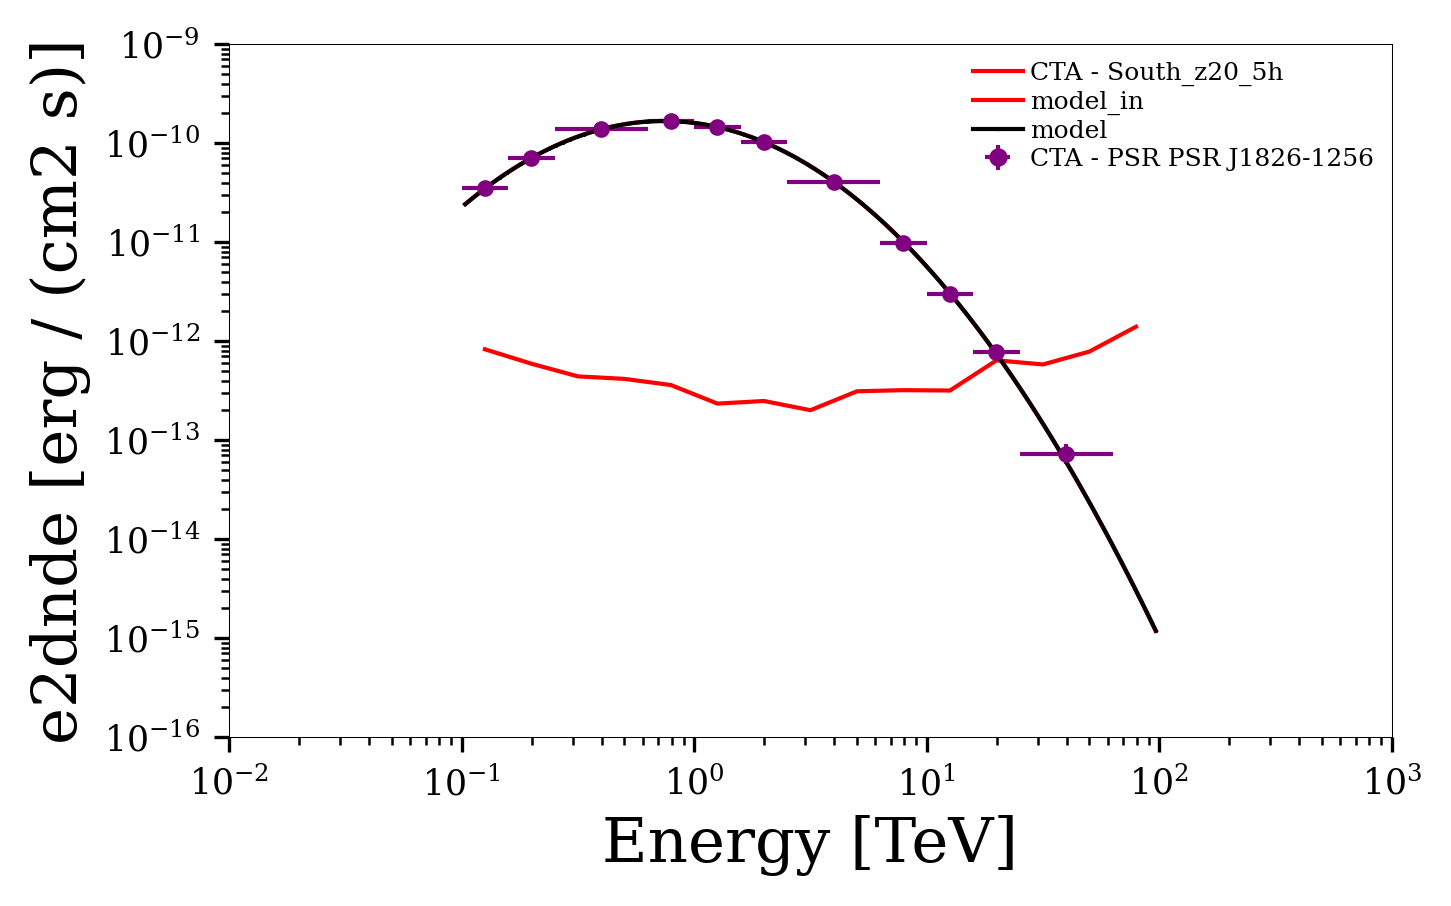

In [85]:
fix, axes = plt.subplots(figsize=(5, 3))
axes.plot(sensitivity_table["energy"], sensitivity_table["e2dnde"], "s-", color="red", label = f"CTA - {irf_name}")
FluxPoints.from_table(table = CTA_table, sed_type='e2dnde').plot(label = f"CTA - PSR {src_jname}")
model_in.plot(energy_bounds=energy_bounds, color="r", sed_type = "e2dnde", label = f"model_in")
model.plot(energy_bounds=energy_bounds, color="k", sed_type = "e2dnde", label = f"model")

plt.legend()
plt.xlim(1e-2, 1000)

In [81]:
model_in.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,amplitude,1.0000e-10,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,2.3000e+00,,0.000e+00,nan,nan,False,False,
spectral,beta,5.0000e-01,,0.000e+00,nan,nan,False,False,


In [82]:
model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,amplitude,9.9796e-11,cm-2 s-1 TeV-1,1.912e-13,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,2.2999e+00,,1.776e-03,nan,nan,False,False,
spectral,beta,4.9954e-01,,1.488e-03,nan,nan,False,False,


In [ ]:
table_CTA_sens = Table.read(f"{path_file}/{file_name_sens}.csv",format='ascii', delimiter=' ', comment='#')

In [ ]:
table_CTA_sens

In [ ]:
f"{path_file}/{file_name_sens}.csv"

In [ ]:
# fix, axes = plt.subplots(figsize=(5, 3))
# axes.plot(table_CTA_sens["energy"], table_CTA_sens["e2dnde"], "s-", color="red", label = "CTA - Sensitivity")
# FluxPoints.from_table(table = CTA_table, sed_type='e2dnde').plot(label = f"CTA - PSR {src_jname}")
# plt.legend()
# plt.xlim(1e-2, 300)


In [ ]:
energy_bounds = [e_edges_min, e_edges_max] * u.TeV

In [ ]:

plt.figure(figsize=(8,5))
absspecmodel.plot(
    energy_bounds, 
    label='logparabola'
)

xerr = [np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref))]

plt.errorbar(
    e_ref, 
    flux_TEV, 
    color='red', 
    marker='o', 
    xerr = xerr, 
    yerr = flux_err_TEV, 
    linestyle='', 
    label='CTA')
# plt.grid(which="both")
plt.ylim(1e-20, 1e-8)
plt.legend(loc="best")
plt.title(src_jname)

# path_flux = mkdir_base_child("analysis", "flux_point")

# plt_savefig(path_flux, "flux_point")

# plt.savefig('./spectrum_srcM87.png', bbox_inches='tight')

# plt.savefig('./M87_gammapy_flux_point.png', bbox_inches='tight')
# plt.savefig('./M87_gammapy_flux_point.pdf', bbox_inches='tight')
plt.savefig(f'./{src_jname}_gammapy_flux_point.png', bbox_inches='tight')
plt.show()


In [ ]:

fix, axes = plt.subplots(figsize=(5, 3))
axes.plot(t["energy"], t["e2dnde"], "s-", color="red")

absspecmodel.plot(
    energy_bounds, 
    label='logparabola'
)

xerr = [np.hstack((e_ref))-np.hstack((e_min)), np.hstack((e_max))-np.hstack((e_ref))]

plt.errorbar(
    energy, 
    flux_TEV, 
    color='red', 
    marker='o', 
    xerr = xerr, 
    yerr = flux_err_TEV, 
    linestyle='', 
    label='CTA')
# plt.grid(which="both")
plt.ylim(1e-30, 1e-5)
plt.legend(loc="best")
plt.title(src_jname)
plt.savefig(f'./{src_jname}_gammapy_flux_point.png', bbox_inches='tight')
plt.show()

___

🔝 [Back to Top](#intro)<br>

In [ ]:
path_file_1 = f"{path_file}/CTA_J1826-1334_sensitivity_South_z20_0.5h.csv"
label_1 = "South_z20_0.5h"
table_sens_1= Table.read(path_file_1,format='ascii', delimiter=' ', comment='#')
path_file_2 = f"{path_file}/CTA_J1826-1334_sensitivity_South_z20_5h.csv"
label_2 = "South_z20_5h"
table_sens_2= Table.read(path_file_2,format='ascii', delimiter=' ', comment='#')
path_file_3 = f"{path_file}/CTA_J1826-1334_sensitivity_South_z20_50h.csv"
label_3 = "South_z20_50h"
table_sens_3= Table.read(path_file_3,format='ascii', delimiter=' ', comment='#')


In [ ]:
def print_sensitivity():
    energy_bounds = [e_edges_min, e_edges_max] 
    ylim = [1e-13, 3e-12]
    fix, axes = plt.subplots(figsize=(5, 3))

    axes.plot(table_sens_1["energy"], table_sens_1["e2dnde"],linestyle=':', marker=4, markersize=0, color='purple', label=label_1)
    axes.plot(table_sens_2["energy"], table_sens_2["e2dnde"], linestyle='solid', marker=4, markersize=0, color='turquoise', label=label_2)
    axes.plot(table_sens_3["energy"], table_sens_3["e2dnde"], linestyle='dashdot', marker=4, markersize=0, color='lime', label=label_3)

    axes.loglog()

#     axes.set_xlabel(f"Energy ({table_sens_1['energy'].unit})", size=13)
#     axes.set_ylabel(f"Sensitivity ({table_sens_1['e2dnde'].unit})", size=13)
    axes.set_ylim(ylim)
    axes.set_xlim(energy_bounds)
    plt.legend()

    plt_savefig(path_sens,  name)

    return

In [ ]:
name = f'sensitivity_{irf_name}_time'
print_sensitivity()

In [ ]:
path_file_1 = f"{path_file}/CTA_J1826-1256_sensitivity_South_z20_0.5h.csv"
label_1 = "South_z20_0.5h"
table_sens_1= Table.read(path_file_1,format='ascii', delimiter=' ', comment='#')
path_file_2 = f"{path_file}/CTA_J1826-1256_sensitivity_South_z20_5h.csv"
label_2 = "South_z20_5h"
table_sens_2= Table.read(path_file_2,format='ascii', delimiter=' ', comment='#')
path_file_3 = f"{path_file}/CTA_J1826-1256_sensitivity_South_z20_50h.csv"
label_3 = "South_z20_50h"
table_sens_3= Table.read(path_file_3,format='ascii', delimiter=' ', comment='#')

In [ ]:
name = f'sensitivity_{irf_name}_time'
print_sensitivity()

In [ ]:
path_file_1 = f"{path_file}/CTA_J1826-1256_sensitivity_South_z20_5h.csv"
label_1 = "South_z20_5h"
table_sens_1= Table.read(path_file_1,format='ascii', delimiter=' ', comment='#')
path_file_2 = f"{path_file}/CTA_J1826-1256_sensitivity_South_z40_5h.csv"
label_2 = "South_z40_5h"
table_sens_2= Table.read(path_file_2,format='ascii', delimiter=' ', comment='#')
path_file_3 = f"{path_file}/CTA_J1826-1256_sensitivity_South_z60_5h.csv"
label_3 = "South_z60_5h"
table_sens_3= Table.read(path_file_3,format='ascii', delimiter=' ', comment='#')

In [ ]:
name = f'sensitivity_{irf_name}_zenit'
print_sensitivity()

In [ ]:
def print_sensitivity2():
    energy_bounds = [e_edges_min, e_edges_max] 
    ylim = [1e-13, 3e-12]
    fix, axes = plt.subplots(figsize=(5, 3))

    axes.plot(table_sens_1["energy"], table_sens_1["e2dnde"],linestyle=':', marker=4, markersize=0, color='purple', label=label_1)
    axes.plot(table_sens_2["energy"], table_sens_2["e2dnde"], linestyle='solid', marker=4, markersize=0, color='turquoise', label=label_2)

    axes.loglog()

    axes.set_xlabel(f"Energy ({table_sens_1['energy'].unit})", size=13)
    axes.set_ylabel(f"Sensitivity ({table_sens_1['e2dnde'].unit})", size=13)
    axes.set_ylim(ylim)
    axes.set_xlim(energy_bounds)
    plt.legend()
    plt_savefig(path_sens,  name)

    return

In [ ]:
path_file_1 = f"{path_file}/CTA_J1826-1256_sensitivity_South_z20_5h.csv"
label_1 = "PSR J1826-1256: South_z20_5h"
table_sens_1= Table.read(path_file_1,format='ascii', delimiter=' ', comment='#')
path_file_2 = f"{path_file}/CTA_J1826-1334_sensitivity_South_z20_5h.csv"
label_2 = "PSR J1826-1334: South_z20_5h"
table_sens_2= Table.read(path_file_2,format='ascii', delimiter=' ', comment='#')

In [ ]:
name = f'sensitivity_{irf_name}_PSR'
print_sensitivity2()

In [ ]:
end_1 = time.perf_counter()

print(f"Time taken is {end_1 - start_1}")

end_2 = datetime.now()

print(f"Time taken in (hh:mm:ss.ms) is {end_2 - start_2}")
 

In [ ]:
ddd